In [ ]:
# import python libraries
import cv2, os, random, importlib, numpy as np
import matplotlib.pyplot as plt 
from PIL import Image
from transformers import SamModel, SamConfig, SamProcessor
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch

os.chdir('../lib')

# import custom scripts 
import preprocess_images
import get_bounding_box

# reload and declare functions 
importlib.reload(preprocess_images)
importlib.reload(get_bounding_box)

from preprocess_images import preprocess_grayscale, preprocess_rgb, preprocess_rgbd
from get_bounding_box import get_bounding_box, get_bounding_box_circumscribed

# double check to make sure the right weights are called 
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

folder_path_model = './models/SAM_rgb.pth'

my_mito_model = SamModel(config=model_config)
my_mito_model.load_state_dict(torch.load('SAM_rgb_new2.pth'))

# set the device to cuda if available, otherwise use cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
my_mito_model.to(device)



/home/am0532/.conda/envs/tumor-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [53]:
train_images, train_masks, val_images, val_masks, test_images, test_masks = preprocess_grayscale('../data/test_data', 100, 0, 0)

Saving Contour Plots: 100%|██████████| 1/1 [00:00<00:00, 10.26it/s]

Number of Images: 1

Number of Train Images: 1
Number of Val Images: 0
Number of Test Images: 0


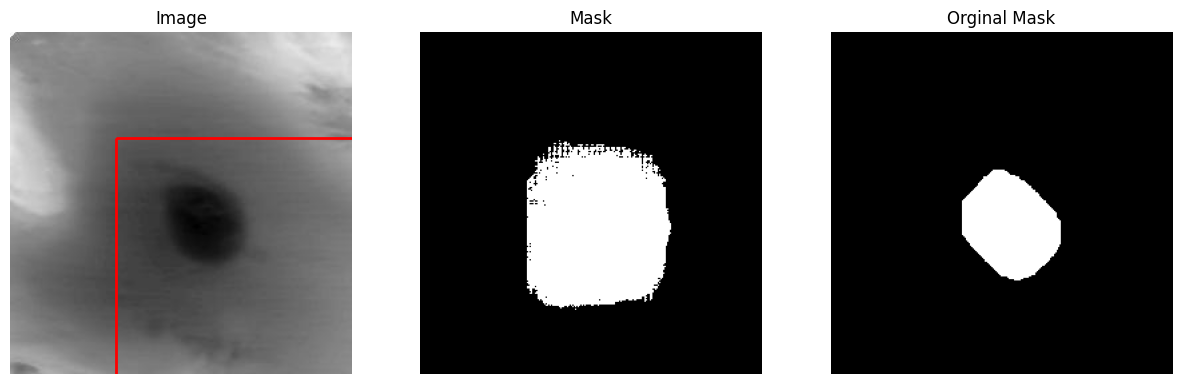

In [56]:
idx = 0

# load image
test_image = train_images[idx]
ground_truth_mask = train_masks[idx]

prompt = get_bounding_box(ground_truth_mask)

inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")
inputs = {k: v.to(device) for k, v in inputs.items()}

my_mito_model.eval()

with torch.no_grad():
    outputs = my_mito_model(**inputs, multimask_output=False)

medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

bbox = prompt
rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=2, edgecolor='r', facecolor='none')
axes[0].add_patch(rect)

axes[0].imshow(np.array(test_image), cmap='gray')
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(medsam_seg, cmap='gray')
axes[1].set_title("Mask")

axes[2].imshow(ground_truth_mask, cmap = "gray")
axes[2].set_title("Orginal Mask")

for ax in axes:
    ax.axis("off")

In [41]:
import monai
from monai.losses import DiceFocalLoss

# calc loss 
seg_loss = DiceFocalLoss(sigmoid=True, squared_pred=True, reduction='mean')

# Convert NumPy arrays to PyTorch tensors
tensor1 = torch.from_numpy(medsam_seg).float().to(device)
tensor2 = torch.from_numpy(ground_truth_mask).float().to(device)

# Initialize the Dice Focal Loss function
seg_loss = DiceFocalLoss(sigmoid=True, squared_pred=True, reduction='mean')

# Compute the loss
loss = seg_loss(tensor1, tensor2)

# Return the loss value
print(loss.item())


1.1755937337875366


In [12]:
# calc total loss
os.chdir('../lib')
import get_loss
importlib.reload(get_loss)

from get_loss import get_loss_rgb

get_loss_rgb("../models/SAM_grayscale.pth")

Number of Images: 275

Number of Train Images: 192
Number of Val Images: 41
Number of Test Images: 42


Calculating Test Loss: 100%|██████████| 42/42 [00:09<00:00,  4.21it/s]


1.1723936881337846